In [92]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

In [93]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [94]:
weekly = load_data('Weekly')
print(weekly.columns)
weekly

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


Exercise 13

            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000 -0.032289 -0.033390 -0.030006 -0.031128 -0.030519  0.841942   
Lag1   -0.032289  1.000000 -0.074853  0.058636 -0.071274 -0.008183 -0.064951   
Lag2   -0.033390 -0.074853  1.000000 -0.075721  0.058382 -0.072499 -0.085513   
Lag3   -0.030006  0.058636 -0.075721  1.000000 -0.075396  0.060657 -0.069288   
Lag4   -0.031128 -0.071274  0.058382 -0.075396  1.000000 -0.075675 -0.061075   
Lag5   -0.030519 -0.008183 -0.072499  0.060657 -0.075675  1.000000 -0.058517   
Volume  0.841942 -0.064951 -0.085513 -0.069288 -0.061075 -0.058517  1.000000   
Today  -0.032460 -0.075032  0.059167 -0.071244 -0.007826  0.011013 -0.033078   

           Today  
Year   -0.032460  
Lag1   -0.075032  
Lag2    0.059167  
Lag3   -0.071244  
Lag4   -0.007826  
Lag5    0.011013  
Volume -0.033078  
Today   1.000000  


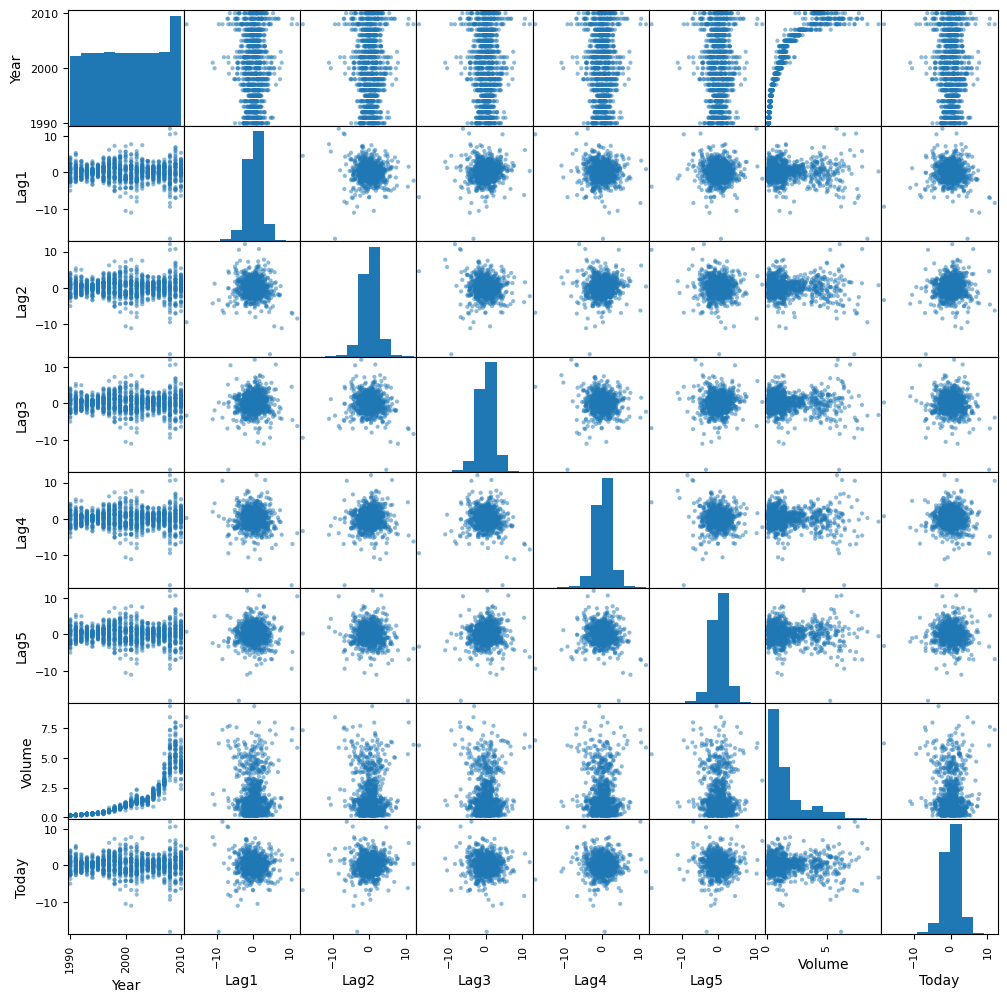

In [95]:
print(weekly.corr(numeric_only=True))
pd.plotting.scatter_matrix(weekly, figsize=(12,12));

In [117]:
allvars=weekly.columns.drop(['Today','Direction','Year'])
design=MS(allvars)
X=design.fit_transform(weekly)
y=weekly.Direction=='Up'
glm=sm.GLM(y,X,family=sm.families.Binomial())
res=glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Sat, 27 Jul 2024   Deviance:                       1486.4
Time:                        15:51:04   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

In [119]:
probs=res.predict()
labels=np.array(['Down']*1089)
labels[probs>0.5]="Up"

In [120]:
confusion_table(labels, weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [121]:
(557+54)/(54+557+430+48)

0.5610651974288338

In [107]:
train = (weekly.Year < 2009)
weekly_train = weekly.loc[train]
weekly_test = weekly.loc[~train]

In [128]:
X_train, X_test = X.loc[train].Lag2, X.loc[~train].Lag2
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()

probs = results.predict(exog=X_test)

X_t=np.array(X_train)
XX=X_t.reshape(np.shape(X_t)[0],1)
X_ts=np.array(X_test)
Xts=X_ts.reshape(np.shape(X_ts)[0],1)

In [ ]:
#Preparing the test set to compare with the corresponding training set in the confusion matrix
D=Weekly.Direction
Test_set=D.loc[~train]
Train_set=D.loc[train]
#Converting the probs matrix to a matrix filled with direction values
labels=np.array(['Down']*104)
labels[probs>0.5]='Up'
C=ISLP.confusion_table(labels,Test_set)
Train_s=np.array(Train_set)
TT=Train_s.reshape(np.shape(Train_set)[0],1)
Test_s=np.array(Test_set)
TS=Test_s.reshape(np.shape(Test_s)[0],1)
TS.shape